Different learning rates, number of epochs, and batch sizes were explored, but the results did not change much.

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import torch.nn as nn

In [2]:
# Load the dataset
df = pd.read_csv("data/hDHFR_pIC50_data.csv")[["CANONICAL_SMILES", "pIC50"]]
print(f'Number of examples is: {len(df)}')
df.head()

Number of examples is: 560


,CANONICAL_SMILES,pIC50
0,Nc1nc(N)c2c(Sc3ccccc3)cccc2n1,6.21
1,COc1ccc(OC)c(Cc2sc3nc(N)nc(N)c3c2C)c1,6.14
2,CN(Cc1coc2nc(N)nc(N)c12)c3ccc(cc3)C(=O)N[C@@H]...,6.66
3,Nc1nc(N)c2nc(CSc3ccc(cc3)C(=O)NC(CCC(=O)O)C(=O...,5.57
4,Nc1nc(N)c2nc(CCSc3ccc(cc3)C(=O)NC(CCC(=O)O)C(=...,4.60


In [3]:
# Load the pre-trained model and tokenizer
model_name = "DeepChem/ChemBERTa-77M-MLM"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Determine the maximum sequence length
max_length = tokenizer.model_max_length
print(max_length)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


512


In [4]:
# Tokenization function
def tokenize(string):
    """
    Tokenize and encode a string using the provided tokenizer.
    
    Parameters:
        string (str): Input string to be tokenized.
    
    Returns:
        Tuple of input_ids and attention_mask.
    """
    encodings = tokenizer.encode_plus(
        string,
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_attention_mask=True
    )
    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]
    return input_ids, attention_mask

# Tokenize the 'CANONICAL_SMILES' column and create new columns 'input_ids' and 'attention_mask'
tqdm.pandas()
df[["input_ids", "attention_mask"]] = df["CANONICAL_SMILES"].progress_apply(lambda x: tokenize(x)).apply(pd.Series)

100%|██████████████████████████████████████| 560/560 [00:00<00:00, 15447.41it/s]


In [5]:
# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=21)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=21)
print(f"There are {len(train_df)} molecules in Train df.")
print(f"There are {len(val_df)} molecules in Val df.")
print(f"There are {len(test_df)} molecules in Test df.")

There are 448 molecules in Train df.
There are 56 molecules in Val df.
There are 56 molecules in Test df.


In [6]:
# Function to convert data to PyTorch tensors
def get_tensor_data(data):
    """
    Convert data to PyTorch tensors.
    
    Parameters:
        data (DataFrame): Input data containing 'input_ids', 'attention_mask', and 'pIC50' columns.
    
    Returns:
        TensorDataset containing input_ids, attention_mask, and labels tensors.
    """
    input_ids_tensor = torch.tensor(data["input_ids"].tolist(), dtype=torch.int32)
    attention_mask_tensor = torch.tensor(data["attention_mask"].tolist(), dtype=torch.int32)
    labels_tensor = torch.tensor(data["pIC50"].tolist(), dtype=torch.float32)
    return TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)

# Create datasets and data loaders
train_dataset = get_tensor_data(train_df)
val_dataset = get_tensor_data(val_df)
test_dataset = get_tensor_data(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
# Loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device("mps")
model.to(device)

epochs = 10
torch.manual_seed(12345)
for epoch in tqdm(range(epochs)):
    # Training loop
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad(set_to_none=True)
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        output_dict = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        predictions = output_dict.logits.squeeze(dim=1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            output_dict = model(input_ids, attention_mask=attention_mask, labels=labels)
            predictions = output_dict.logits.squeeze(dim=1)
            loss = criterion(predictions, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"epoch {epoch + 1}: Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}")


 10%|████▍                                       | 1/10 [00:04<00:37,  4.12s/it]

epoch 1: Train Loss 13.7115, Val Loss 3.4070


 20%|████████▊                                   | 2/10 [00:07<00:29,  3.68s/it]

epoch 2: Train Loss 1.8040, Val Loss 1.3049


 30%|█████████████▏                              | 3/10 [00:10<00:24,  3.54s/it]

epoch 3: Train Loss 1.4318, Val Loss 1.2696


 40%|█████████████████▌                          | 4/10 [00:14<00:20,  3.48s/it]

epoch 4: Train Loss 1.4239, Val Loss 1.2848


 50%|██████████████████████                      | 5/10 [00:17<00:17,  3.44s/it]

epoch 5: Train Loss 1.4157, Val Loss 1.3262


 60%|██████████████████████████▍                 | 6/10 [00:21<00:13,  3.42s/it]

epoch 6: Train Loss 1.3806, Val Loss 1.2986


 70%|██████████████████████████████▊             | 7/10 [00:24<00:10,  3.44s/it]

epoch 7: Train Loss 1.3577, Val Loss 1.2738


 80%|███████████████████████████████████▏        | 8/10 [00:27<00:06,  3.46s/it]

epoch 8: Train Loss 1.3578, Val Loss 1.2921


 90%|███████████████████████████████████████▌    | 9/10 [00:31<00:03,  3.47s/it]

epoch 9: Train Loss 1.3547, Val Loss 1.3023


100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.49s/it]

epoch 10: Train Loss 1.3551, Val Loss 1.3414


In [8]:
# Testing loop
total_test_loss = 0
test_labels = []
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        output_dict = model(input_ids, attention_mask=attention_mask, labels=labels)
        predictions = output_dict.logits.squeeze(dim=1)
        loss = criterion(predictions, labels)
        total_test_loss += loss.item()
        test_labels.extend(labels.tolist())
        test_predictions.extend(predictions.tolist())
avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss {avg_test_loss:.4f}")

Test Loss 1.4417


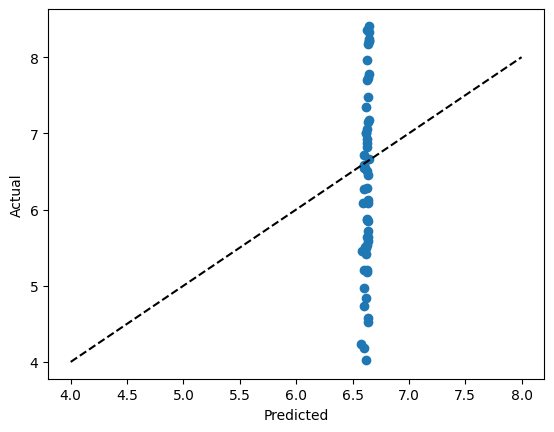

In [9]:
import matplotlib.pyplot as plt
plt.scatter(test_predictions, test_labels)
plt.plot([4, 8], [4, 8], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual');